In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
	sys.path.append(nb_dir)

In [2]:
import torch
import torch.nn as nn
from torch.optim.radam import RAdam

from general_utils import AttrDict
from reward_induced.models.reward_predictor_model import RewardPredictorModel
from reward_induced.models.decoder import ImageDecoder
from reward_induced.utils import *
from sprites_datagen.moving_sprites import MovingSpriteDataset, TemplateMovingSpritesGenerator
from sprites_datagen.rewards import *

from tqdm import trange
import matplotlib.pyplot as plt

/home/thisiswooyeol/anaconda3/envs/2024Spring/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
spec = AttrDict(
        resolution=64,
        max_seq_len=30,
        max_speed=0.05,      # total image range [0, 1]
        obj_size=0.2,       # size of objects, full images is 1.0
        shapes_per_traj=4,      # number of shapes per trajectory
        rewards=[ZeroReward],
    )

dataset = MovingSpriteDataset(spec)

In [4]:
# some hyperparameters
image_shape = (3, 64, 64)
n_frames = 20  # number of conditioning frames
T_future = 10  # number of future frames to predict rewards for
batch_size = 32

lr = 1e-3
n_iter = 2_000
log_interval = 200

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train an ImageDecoder from complete images to reward-induced representation

In [5]:
RPM_PATH = 'complete_RPM_1e-3_1M.pth'

model = RewardPredictorModel(image_shape, n_frames, T_future)
model.load_state_dict(torch.load(RPM_PATH))

# with learned image encoder, decode reward-induced representations
encoder = model.image_encoder
decoder = ImageDecoder(image_shape)

In [6]:
loss_fn = nn.MSELoss()
optimizer = RAdam(decoder.parameters(), lr=lr)

In [7]:
def train_decoder(encoder, decoder, dataset, device, n_iter):
    # decoder should restore the original image from the reward-induced representation
    losses = []
    encoder.to(device).eval()
    decoder.to(device)
    print(f'[INFO] Train decoder on device: {device} ...')

    for itr in trange(n_iter):
        images, _ = generate_batch(dataset, batch_size, itr)
        images = images.to(device)
		
        # encode the images
        with torch.no_grad():
            encoded_repr = encoder(images).detach() 
        
        # decode the images
        decoded_images = decoder(encoded_repr)

        loss = loss_fn(decoded_images, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if (itr+1) % log_interval == 0:
            print(f'[{itr+1} / {n_iter}] Reproduction loss: {loss.item()}')

    return losses

In [8]:
losses_decoder = train_decoder(encoder, decoder, dataset, device, n_iter)

[INFO] Train decoder on device: cuda ...


 10%|█         | 200/2000 [00:50<07:06,  4.22it/s]

[200 / 2000] Reproduction loss: 0.41431140899658203


 20%|██        | 400/2000 [01:40<06:26,  4.14it/s]

[400 / 2000] Reproduction loss: 0.2260720431804657


 30%|███       | 600/2000 [02:30<05:34,  4.18it/s]

[600 / 2000] Reproduction loss: 0.19049830734729767


 40%|████      | 800/2000 [03:19<04:43,  4.24it/s]

[800 / 2000] Reproduction loss: 0.16843678057193756


 50%|█████     | 1000/2000 [04:13<06:01,  2.77it/s]

[1000 / 2000] Reproduction loss: 0.15773186087608337


 60%|██████    | 1200/2000 [05:06<04:47,  2.78it/s]

[1200 / 2000] Reproduction loss: 0.15590742230415344


 70%|███████   | 1400/2000 [06:00<02:30,  3.99it/s]

[1400 / 2000] Reproduction loss: 0.14920860528945923


 80%|████████  | 1600/2000 [06:50<01:40,  3.98it/s]

[1600 / 2000] Reproduction loss: 0.14713716506958008


 90%|█████████ | 1800/2000 [07:39<00:52,  3.82it/s]

[1800 / 2000] Reproduction loss: 0.1418384611606598


100%|██████████| 2000/2000 [08:28<00:00,  3.93it/s]

[2000 / 2000] Reproduction loss: 0.13966138660907745


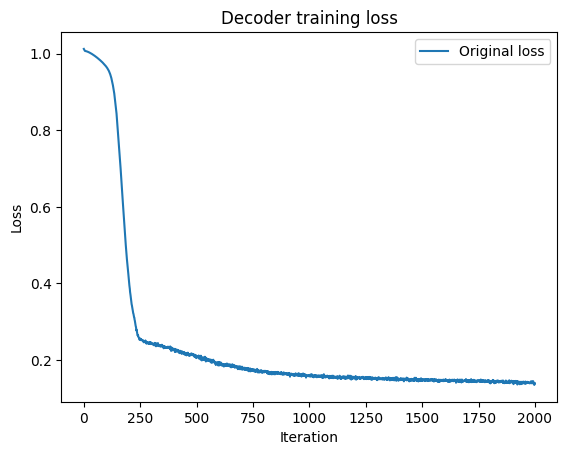

In [9]:
# Visualize the losses
plt.plot(losses_decoder, label='Original loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Decoder training loss')
plt.legend()
plt.show()

In [10]:
DECODER_PATH = 'complete_decoder_tanh_4K.pth'
torch.save(decoder.state_dict(), DECODER_PATH)

In [11]:
decoder = ImageDecoder(image_shape)
decoder.load_state_dict(torch.load(DECODER_PATH))  # test save and load

<All keys matched successfully>

# Decode the reward-induced representation

In [12]:
spec = AttrDict(
        resolution=64,
        max_seq_len=30,
        max_speed=0.05,      # total image range [0, 1]
        obj_size=0.2,       # size of objects, full images is 1.0
        shapes_per_traj=1,      # number of shapes per trajectory
        rewards=[VertPosReward, HorPosReward],
    )

generator = TemplateMovingSpritesGenerator(spec)
generator.SHAPES = ['tri_bottom']

In [13]:
from general_utils import make_image_seq_strip
import cv2

output = generator.gen_trajectory()
images = make_image_seq_strip([output['images'][None, :, None].repeat(3, axis=2).astype(np.float32)], \
                              sep_val=255.0).astype(np.uint8)

print(output['images'].shape)
cv2.imwrite('one_distractor.png', images[0].transpose(1, 2, 0))

print(output['rewards'])

(30, 64, 64)
{'vertical_position': array([0.6523922 , 0.70016897, 0.7479458 , 0.7957226 , 0.8434994 ,
       0.89127624, 0.86094695, 0.8131702 , 0.7653934 , 0.71761656,
       0.66983974, 0.6220629 , 0.57428616, 0.52650934, 0.47873253,
       0.4309557 , 0.38317892, 0.3354021 , 0.28762528, 0.2398485 ,
       0.19207168, 0.14429487, 0.10348193, 0.15125874, 0.19903554,
       0.24681234, 0.29458916, 0.34236595, 0.39014277, 0.4379196 ],
      dtype=float32), 'horizontal_position': array([0.4887402 , 0.49825358, 0.50776696, 0.51728034, 0.5267937 ,
       0.5363071 , 0.5458205 , 0.55533385, 0.56484723, 0.57436055,
       0.5838739 , 0.5933873 , 0.6029007 , 0.61241406, 0.62192744,
       0.6314408 , 0.6409542 , 0.6504676 , 0.65998095, 0.66949433,
       0.6790077 , 0.6885211 , 0.69803447, 0.70754784, 0.7170612 ,
       0.7265746 , 0.736088  , 0.74560136, 0.75511473, 0.7646281 ],
      dtype=float32)}
{'vertical_position': array([0.6523922 , 0.70016897, 0.7479458 , 0.7957226 , 0.8434994 ,
   

### Decode vertical reward-induced representations with ImageDecoder

In [14]:
model_vertical = RewardPredictorModel(image_shape, n_frames, T_future)
model_vertical.load_state_dict(torch.load(RPM_PATH))

decoder_vertical = ImageDecoder(image_shape)
decoder_vertical.load_state_dict(torch.load(DECODER_PATH))

<All keys matched successfully>

In [15]:
images, rewards = generate_batch_gen(generator, 3)

images.shape

torch.Size([3, 30, 3, 64, 64])

In [16]:
loss_fn = nn.MSELoss()
optimizer = RAdam(model_vertical.parameters(), lr=5e-4)  # lr / 2

In [17]:
def finetune_RPM_single_reward(model, generator, loss_fn, optimizer, device, reward_type):
	losses = []
	model.to(device)
	print(f'[INFO] Finetune RPM with {reward_type} reward on device: {device} ...')

	for itr in trange(n_iter):
		images, rewards = generate_batch_gen(generator, batch_size)
		
		# assume n_frames + T_future == len(images)
		pred_rewards = model(  # add batch dimension for images
			conditioning_frames=images[:, :n_frames].to(device), 
			future_frames=images[:, n_frames:].to(device),
			reward_type=reward_type
		)

		loss = 0
		for reward_type, pred_reward in pred_rewards.items():
			reward = torch.tensor(rewards[reward_type][:, n_frames:], 
						 dtype=torch.float32, device=device)
			loss += loss_fn(pred_reward, reward)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		losses.append(loss.item())
		if (itr+1) % log_interval == 0:
			print(f'[{itr+1} / {n_iter}] RPM loss: {loss.item()}')

	return losses

In [20]:
finetune_RPM_single_reward(model_vertical, generator, loss_fn, optimizer, device, ['vertical_position'])

[INFO] Finetune RPM with ['vertical_position'] reward on device: cuda ...


  0%|          | 1/2000 [00:00<19:55,  1.67it/s]


AssertionError: 

In [ ]:
with torch.no_grad():
    # encode the images
    encoded_repr = model_vertical.image_encoder(images[:, :n_frames].to(device))
    decoded_images = decoder_vertical(encoded_repr)

decoded_images = decoded_images.cpu().numpy()
decoded_images = make_image_seq_strip([decoded_images[:, None, :, None]], sep_val=255.0).astype(np.uint8)
cv2.imwrite('vertical_decoded.png', decoded_images[0].transpose(1, 2, 0))

### Decode horizontal reward-induced representations with ImageDecoder